## 0. Import and Read Data (CURRENTLY WORKING)

**IMPORTANT**: This code is written with Python 3 and appropiate installation is required.  

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

We first need to read the data to solve the **recommendation** problem.

In [5]:
#Importing data and setting the index to datetime
df=pd.read_csv('Online Retail.csv', parse_dates=True, index_col="InvoiceDate")

Checked the data to see if there were any missing values and to obtain the types of data. 

In [6]:
#Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 541909 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# 00. Data Cleaning

We first want to observe the raw data to see if there are things that stick out, also looking for patterns. 

In [7]:
#Looking at the data set to observe visual trends
print(df)

                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365    84406B       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
2010-12-01 08:26:00    536365     22752         SET 7 BABUSHKA NESTING BOXES   
2010-12-01 08:26:00    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
2010-12-01 08:28:00    536366     22633               HAND WARMER UNION JACK   
2010-12-01 08:28:00    536366     22632            HAND WARMER RED POLKA DOT   
2010-12-01 08:34:00    536367     84879        ASSORTED COLOUR BIRD ORNAMENT   
2010-12-01 08:34:00    536367     22745 

Upon observation, we know the company is completly online, remove the **Country** column. Strip the letters from the **StockCode** column to make an integer and drop the **promotional items** because they were given (Items that were free, or **UnitPrice = 0**. We only care about items customers wanted to buy.

In [8]:
# Drop the Country column because it is not needed.
df_dropped=df.drop(['Country'],axis=1)
# Remove data where unit price and quantity is positive. 
df_pos_price = df_dropped.loc[lambda df_dropped: (df_dropped['UnitPrice'] > 0) & (df_dropped['Quantity'] > 0)]
# Stip the letters from the StockCode.
df_pos_price['StockCode'] = df_pos_price['StockCode'].str.strip('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz')
# Replace missing values with NaN.
df_pos_price.replace('', np.nan, inplace = True)
print(df_pos_price)

C:\Users\dixon\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


                    InvoiceNo StockCode                          Description  \
InvoiceDate                                                                    
2010-12-01 08:26:00    536365     85123   WHITE HANGING HEART T-LIGHT HOLDER   
2010-12-01 08:26:00    536365     71053                  WHITE METAL LANTERN   
2010-12-01 08:26:00    536365     84406       CREAM CUPID HEARTS COAT HANGER   
2010-12-01 08:26:00    536365     84029  KNITTED UNION FLAG HOT WATER BOTTLE   
2010-12-01 08:26:00    536365     84029       RED WOOLLY HOTTIE WHITE HEART.   
2010-12-01 08:26:00    536365     22752         SET 7 BABUSHKA NESTING BOXES   
2010-12-01 08:26:00    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
2010-12-01 08:28:00    536366     22633               HAND WARMER UNION JACK   
2010-12-01 08:28:00    536366     22632            HAND WARMER RED POLKA DOT   
2010-12-01 08:34:00    536367     84879        ASSORTED COLOUR BIRD ORNAMENT   
2010-12-01 08:34:00    536367     22745 

C:\Users\dixon\Anaconda3\lib\site-packages\pandas\core\frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [48]:
df_pos_price.describe()

,Quantity,UnitPrice,CustomerID
count,530104.000000,530104.000000,397884.000000
mean,10.542037,3.907625,15294.423453
std,155.524124,35.915681,1713.141560
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15159.000000
75%,10.000000,4.130000,16795.000000
max,80995.000000,13541.330000,18287.000000


# 1. Data Manipulation

We first need to see how many customers bought items. To give an accurate recommendation, we want to make sure the data we are observing is based on frequent shoppers, and not periodic or one-time shoppers. To do so, we need to first observe the data by the actual **CustomerID** where we then want to see how many items each customer purchased.

In [9]:
#observe the data where we have all column data 
CustomerID = df_pos_price.groupby('CustomerID').count()
print(CustomerID)

            InvoiceNo  StockCode  Description  Quantity  UnitPrice
CustomerID                                                        
12346.0             1          1            1         1          1
12347.0           182        182          182       182        182
12348.0            31         27           31        31         31
12349.0            73         72           73        73         73
12350.0            17         16           17        17         17
12352.0            85         77           85        85         85
12353.0             4          4            4         4          4
12354.0            58         58           58        58         58
12355.0            13         13           13        13         13
12356.0            59         58           59        59         59
12357.0           131        131          131       131        131
12358.0            19         17           19        19         19
12359.0           248        248          248       248       

We now want to remove the customers that did not purchase more than 50 times at the store. We only want customers who have purchased at least 50 times, therefore, we look at the **InvoiceNo** column and manipulate, accordingly. 

In [10]:
# Customers less than 50 orders
df_clean=CustomerID.loc[lambda CustomerID: CustomerID['InvoiceNo'] > 50]
print(df_clean)

            InvoiceNo  StockCode  Description  Quantity  UnitPrice
CustomerID                                                        
12347.0           182        182          182       182        182
12349.0            73         72           73        73         73
12352.0            85         77           85        85         85
12354.0            58         58           58        58         58
12356.0            59         58           59        59         59
12357.0           131        131          131       131        131
12359.0           248        248          248       248        248
12360.0           129        126          129       129        129
12362.0           266        256          266       266        266
12364.0            85         81           85        85         85
12370.0           167        166          167       167        167
12371.0            63         62           63        63         63
12372.0            52         49           52        52       

Create a DataFrame that indexed by the **StockCode** and use the **CustomerID** as the columns where we figured the values to be the **Quantity** shared between them. Normalize the data.

In [51]:
# New DataFrame created to view the relationship between the custumer and the items purchased filling NaN with 0.
cluster1 = df_clean.pivot_table(index='StockCode', columns='CustomerID', values='Quantity', aggfunc = np.sum).fillna(value=0)
# Normalizing the data.
cluster1_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster1_minmax)

C:\Users\dixon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


[[0.01680349 0.01720154 0.01680349 0.01680349 0.01680349]
 [0.00282196 0.00308087 0.00282196 0.00282196 0.00282196]
 [0.00436121 0.00372272 0.00436121 0.00436121 0.00436121]
 ...
 [0.01475115 0.01514763 0.01475115 0.01475115 0.01475115]
 [0.09043099 0.09062901 0.09043099 0.09043099 0.09043099]
 [0.00243715 0.00282413 0.00243715 0.00243715 0.00243715]]


Figured out the *optimal* **k** (number of clusters) for the DataFrame using the **Elbow Method** by obtaining initializing a range of values for **k**. We then plot this data to observe the plot for the **Elbow Point** which gives the optimal **k**. 

In [12]:
# Gave a range for K to obtain the list of K values
Sum_of_squared = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster1_minmax)
    Sum_of_squared.append(km.inertia_)

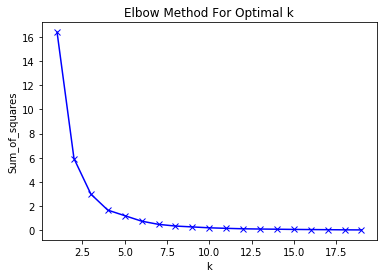

In [52]:
# Create the plot that will produce the elbow plot to give optimal value of k.
plt.plot(K, Sum_of_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

Create a DataFrame that indexed by the **CustomerID** and use the **StockCode** as the columns where we figured the values to be the **Quantity** shared between them. Normalize the data.

In [14]:
# New DataFrame created to view the relationship between the custumer and the items purchased filling NaN with 0.
cluster2 = df_clean.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc = np.sum).fillna(value=0)
# Normalized the data.
cluster2_minmax = MinMaxScaler().fit_transform(df_clean)
print(cluster1_minmax)

[[0.01680349 0.01720154 0.01680349 0.01680349 0.01680349]
 [0.00282196 0.00308087 0.00282196 0.00282196 0.00282196]
 [0.00436121 0.00372272 0.00436121 0.00436121 0.00436121]
 ...
 [0.01475115 0.01514763 0.01475115 0.01475115 0.01475115]
 [0.09043099 0.09062901 0.09043099 0.09043099 0.09043099]
 [0.00243715 0.00282413 0.00243715 0.00243715 0.00243715]]


C:\Users\dixon\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# 2.0 Recommedation

## 2.1 Recommendation (Clustering)

Figured out the *optimal* **k** (number of clusters) for the DataFrame using the **Elbow Method** by obtaining initializing a range of values for **k**. We then plot this data to observe the plot for the **Elbow Point** which gives the optimal **k**. 

In [58]:
# Gave a range for K to obtain the set of K values
Sum_of_squared2 = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster2_minmax)
    Sum_of_squared2.append(km.inertia_)

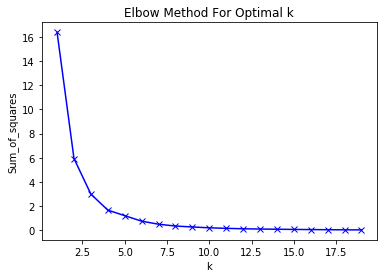

In [59]:
# Create the plot that will produce the elbow plot to give optimal value of k.
plt.plot(K, Sum_of_squared2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squares')
plt.title('Elbow Method For Optimal k')
plt.show()

From observations above, it seems the the optimal K=3. We now can use this to give the number of recommended products of most purchased. 

## 2.2 Recommendation (Most Purchased item)

We want to figure out how many of each product was purchased. Therefore, we need to group our original data by the **StockCode** to see how many customers purchased the item. This will allow us to see which item was purchased the most of all items. Once we have this data, we now recommend this item to all customers. 

In [66]:
rec1 = pd.DataFrame(df_pos_price.groupby('StockCode').count().sort_values(by='CustomerID',ascending=False))
most_purchased = rec1['CustomerID'].head(3)
print(most_purchased)

StockCode
85099    2941
85123    2035
22423    1723
Name: CustomerID, dtype: int64


## 2.3 Recommendation (New Items purchased)

Extract the products that only **one** customer purchased. These products that are considered **new** since it has no purchase history. Recommend this product to all customers.

In [61]:
new_prod = rec1.loc[lambda rec1: rec1['CustomerID'] == 1].sort_values(by = 'CustomerID', ascending = False)
new_product = new_prod['CustomerID']
print(new_product)

StockCode
22034    1
84620    1
84746    1
20964    1
23664    1
84705    1
84016    1
85224    1
71143    1
20678    1
35650    1
90167    1
20667    1
84773    1
90135    1
90197    1
20892    1
23843    1
84227    1
22351    1
20703    1
47579    1
82615    1
22146    1
22275    1
90187    1
22218    1
90028    1
47016    1
90182    1
        ..
90055    1
44265    1
90165    1
90054    1
90069    1
84854    1
84387    1
90071    1
90128    1
21414    1
77079    1
90102    1
23449    1
90078    1
90104    1
37461    1
21667    1
90084    1
21895    1
21839    1
22125    1
90076    1
84551    1
37471    1
84550    1
17001    1
90118    1
84539    1
90100    1
22323    1
Name: CustomerID, Length: 84, dtype: int64


In [47]:
df_train = df_clean2.head(2734)
df_test = df_clean2.tail(304)
print(df_train)

           InvoiceNo  Description  Quantity  UnitPrice  CustomerID
StockCode                                                         
85099           3892         3892      3892       3892        2941
85123           2332         2332      2332       2332        2035
22423           2017         2017      2017       2017        1723
47566           2177         2177      2177       2177        1713
84879           1489         1489      1489       1489        1408
85049           1795         1795      1795       1795        1361
20725           1595         1595      1595       1595        1317
84997           1724         1724      1724       1724        1302
22720           1399         1399      1399       1399        1159
20727           1328         1328      1328       1328        1105
23203           1249         1249      1249       1249        1098
22383           1326         1326      1326       1326        1083
21212           1370         1370      1370       1370        

In [24]:
P = df_train.loc[lambda df_train: df_train['CustomerID'] >= 750]
most_purchased = pd.DataFrame(P, columns = ['CustomerID'])
print(most_purchased)

           CustomerID
StockCode            
85099            2941
85123            2035
22423            1723
47566            1713
84879            1408
85049            1361
20725            1317
84997            1302
22720            1159
20727            1105
23203            1098
22383            1083
21212            1068
22197            1068
23209            1029
23298            1024
22086            1019
22382            1008
20728             989
84596             988
22469             985
22457             980
22384             957
21034             952
22727             899
23206             895
22993             893
22386             890
82482             887
22960             887
22961             875
22138             867
22666             843
20726             842
23084             842
22139             833
22178             825
82494             820
22470             819
15056             810
22726             808
22411             803
22699             801
20914     